# SI 618 - Homework #2: More Data Manipulation

# Background
You're a Data Science Consultant for an eCommerce retail company, they've asked you to analyze their sales database. Unfortunately, they did nothing to prepare or clean their data, only exporting their 3 database tables as JSON files. It's up to you to clean their data, analyze it and answer questions to help drive business value!

### The below files have been provided via the URLs shown:
- invoices.json https://github.com/umsi-data-science/data/raw/main/invoices.json
- items.json https://github.com/umsi-data-science/data/raw/main/items.json
- purchases.json https://github.com/umsi-data-science/data/raw/main/purchases.json

### They provided this data dictionary:

**InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction.  
**StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.  
**Description:** Product (item) name. Nominal.   
**Quantity:** The quantities of each product (item) per transaction. Numeric.  
**InvoiceDate:** Invoice Date and time. Numeric, the day and time when each transaction was generated.  
**UnitPrice:** Unit price. Numeric, Product price per unit in sterling.  
**CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.  
**Country:** Country name. Nominal, the name of the country where each customer resides.  

### A few notes from the company:
* If the InvoiceNo starts with the letter 'c', it indicates a cancellation. When conducting this analysis we only want to analyze invoices that were shipped. (ie. not canceled)
* The datasets should be able to be merged, each row in the invoice table corresponds to multiple rows in the purchases table.
* To find out the description or unit cost of an item in the purchase table, the StockCode should be used to match up the product in the items table. 
* They mentioned that they've been having a difficult time lately joining the items and purchases table, maybe there's something wrong with the columns?

### The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, punctuation, etc. of written sentences. ([Guide](https://drive.google.com/file/d/1L0P7xJwjUGBvyb49mL3dw1Bt7hzRTiTl/view ))
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

Version 2024.01.23.2.CT

# Answer the questions below.
- write your Python code that can answer the following questions 
- explain **ALL** your answers in plain English. 
- you can use as many code and markdown cells as you need for each question (i.e. don't limit yourself to just one of each if you feel you need more).

In [94]:
MY_UNIQNAME = 'jonasxie'  # replace this with your uniqname

### <span style="color:magenta"> Q1. [5 points] Describe the dataset. </span>
1. Load the data. 
1. How many total invoices have been placed?
1. How many unique customers are there?
1. What is the total number of unique items?
1. Are there any columns with null values?
1. Thinking ahead, how do you think you would join the different tables? Please share 2-3 sentences about your approach.

In [95]:
# Dependencies
import pandas as pd
import numpy as np

In [96]:
# load the json data from the link
DATA_INVOICES = pd.read_json("https://github.com/umsi-data-science/data/raw/main/invoices.json")
DATA_ITEMS = pd.read_json("https://raw.githubusercontent.com/umsi-data-science/data/main/items.json")
DATA_PURCHASES = pd.read_json("https://raw.githubusercontent.com/umsi-data-science/data/main/purchases.json")

In [97]:
# Describe the datasets to have a basic sense of the datasets
DATA_INVOICES.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25943 entries, 0 to 25942
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    25943 non-null  object 
 1   InvoiceDate  25943 non-null  object 
 2   CustomerID   22221 non-null  float64
 3   Country      25943 non-null  object 
dtypes: float64(1), object(3)
memory usage: 810.8+ KB


In [98]:
DATA_ITEMS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StockCode    4070 non-null   object 
 1   Description  3894 non-null   object 
 2   UnitPrice    4070 non-null   float64
dtypes: float64(1), object(2)
memory usage: 95.5+ KB


In [99]:
DATA_PURCHASES.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   InvoiceNo    541909 non-null  object
 1   StockCodeSC  541909 non-null  object
 2   Quantity     541909 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 12.4+ MB


In [100]:
# Calculate the number of the invoices
num_invoices = DATA_INVOICES.shape[0]
num_invoices

25943

**Q1.2**: There are 25943 invoices in the dataset.

In [101]:
# Q1.3 Calculate the number of unique customers
num_unique_customers = DATA_INVOICES['CustomerID'].nunique()
num_unique_customers

4372

**Q1.3**: There are 4372 unique customers in the dataset.

In [102]:
# Q1.4 Calculate the number of unique items
num_unique_items = DATA_ITEMS['StockCode'].nunique()
num_unique_items

4070

**Q1.4**: There are 4070 unique items in the dataset.

In [103]:
# Q1.5 Check the null values in each dataset
print("Missing values in Invoice Dataset:")
print(DATA_INVOICES.isnull().sum())
print("\n")
print("Missing values in Items Dataset:")
print(DATA_ITEMS.isnull().sum())
print("\n")
print("Missing values in Purchases Dataset:")
print(DATA_PURCHASES.isnull().sum())

Missing values in Invoice Dataset:
InvoiceNo         0
InvoiceDate       0
CustomerID     3722
Country           0
dtype: int64


Missing values in Items Dataset:
StockCode        0
Description    176
UnitPrice        0
dtype: int64


Missing values in Purchases Dataset:
InvoiceNo      0
StockCodeSC    0
Quantity       0
dtype: int64


**Q1.5**: There are 3722 null values in the `CustomerID` column of the invoice dataset. There are 176 null values in the `Description` column of the items dataset.

**Q1.6**: To join the datasets, I will first join the `Items` table to the `Purchases` by using the `StockCode` column in the `items` dataset and `StockCodeSC` in `Purchases` to match up products, add their `UnitPrice` and calculate the total spending for each product in the new `Purchase_Items` dataset. Then, I will use the `InvoiceNo` column in the `invoices` dataset to merge to the `Purchase_Items` dataset.

### <span style="color:magenta"> Q2. [10 points] Invoice Analysis </span>
1. For each customer calculate how many total invoices they have placed. List the top 10 customers who have placed an invoice in descending order.
2. Perform a similar calculation but instead of the number of invoices, calculate the total quantity of items ordered for each customer. List the top 10 customers in descending order.
3. Compare the top 10 customers, does it appear that the more invoices a customer have, the greater the total quantity of items? Explain your reasoning.

_Hint: For 2.2, you may need to join two datasets together to answer the question._

In [104]:
# Q2.1 List the top ten customers have placed most invoices
DATA_INVOICES['CustomerID'].value_counts().head(10)

CustomerID
14911.0    249
12748.0    225
17841.0    169
14606.0    130
13089.0    118
15311.0    118
12971.0     89
14527.0     86
13408.0     81
14646.0     77
Name: count, dtype: int64

In [105]:
# Q2.2 List the top ten customers have purchased the most items
## left join purchase to the invoice dataset on the invoice number
data_invoices_purchase = pd.merge(DATA_INVOICES, DATA_PURCHASES, on='InvoiceNo', how='left')

## calculate the number of items purchased by each customer and list the top ten customers
data_invoices_purchase['CustomerID'].value_counts().head(10)

CustomerID
17841.0    7983
14911.0    5942
14096.0    5128
12748.0    4731
14606.0    2840
15311.0    2491
14646.0    2085
13089.0    1857
13263.0    1677
14298.0    1640
Name: count, dtype: int64

**Q2.3**: The top 10 customers who have placed the most invoices are not the same as the top 10 customers with most items. This could be due to the fact that some customers place more orders with less items for each order, while others place fewer but larger orders. It weakens the correlation between the quantities of invoices placed and the quantities of items ordered.

### <span style="color:magenta"> Q3. [10 points] Item Analysis </span>
1. What is the average item-unit price? 
1. What % of items are under $25?
1. Generate a histogram of the unit prices. Select reasonable min/max values for the x-axis. Why did you pick those values? What do you notice about the histogram? 

In [106]:
# Q3.1 Calculate the average item-unit price
average_item_unit_price = DATA_ITEMS['UnitPrice'].mean()
round(average_item_unit_price,2)

np.float64(6.91)

**Q3.1**: The average item-unit price is about $6.91.

In [107]:
# Q3.2 Calculate the percentage of items with price under $25
round(DATA_ITEMS[DATA_ITEMS['UnitPrice'] < 25].shape[0] / DATA_ITEMS.shape[0],3)

0.987

**Q3.2**: About 98.7% of the items that are under $25.

<Axes: ylabel='Frequency'>

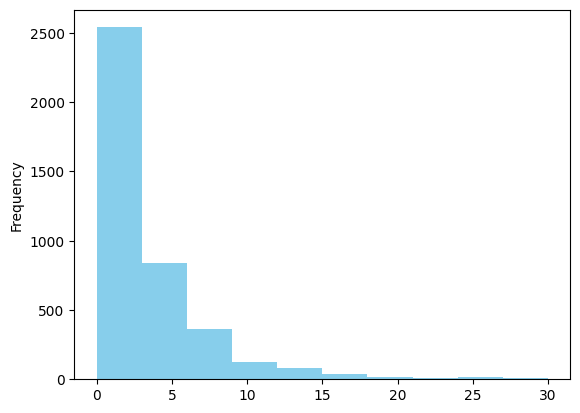

In [108]:
# Q3.3
## Generate a histogram of the item prices
DATA_ITEMS['UnitPrice'].plot(kind='hist', bins=10, range=(0,30), color='skyblue')

In [109]:
DATA_ITEMS['UnitPrice'].describe() # check the descriptive statistics of the item prices
# The quartile values show that 75% of the items have prices less than 4.25.

count     4070.000000
mean         6.905278
std        173.775142
min          0.000000
25%          1.250000
50%          2.510000
75%          4.250000
max      11062.060000
Name: UnitPrice, dtype: float64

In [110]:
# Check the percentage of items with price under $30
round(DATA_ITEMS[DATA_ITEMS['UnitPrice'] <= 30].shape[0] / DATA_ITEMS.shape[0],3)
# 99.2% of the items have prices less than $30.

0.992

**Q3.3**: I picked the min value as 0 and max value as 30 for the x-axis of the histogram. Setting min as 0 because a unit price cannot be negative. Also, the quartile shows that there are 25% of the items with a price below $1.25. Setting max as 30 is mainly because most of the items (99%) are priced under $30. Setting the max value as 30 allows us to see the detailed distribution of most of the items.

### <span style="color:magenta"> Q4. [25 points] Order Trends </span>
1. What are the top 10 most ordered items? Describe them. Do you see any trends?  
1. What are the top 5 invoices that generated the most revenue? (Revenue is calculated by "marking up" the unit price by 25%.) 
1. Do the top 5 invoices contain any of the top 10 most ordered items?

_Hint: When calculating the revenue we suggest adding a new column on the dataframe._

In [111]:
# Q4.1 List the top 10 most ordered items.
## Add "SC" to each StockCode in the item dataset to match the StockCode in the item dataset
DATA_ITEMS['StockCodeSC'] =  'SC' + DATA_ITEMS['StockCode'].str.upper()

In [112]:
## Join the item data to the purchase data to get the item description

data_purchase_item = pd.merge(DATA_PURCHASES, DATA_ITEMS, on='StockCodeSC', how='left')
data_purchase_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562799 entries, 0 to 562798
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    562799 non-null  object 
 1   StockCodeSC  562799 non-null  object 
 2   Quantity     562799 non-null  int64  
 3   StockCode    560822 non-null  object 
 4   Description  559366 non-null  object 
 5   UnitPrice    560822 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 25.8+ MB


In [113]:
## Check the descriptive statistics
data_purchase_item.describe()
## Found abnormal values in the Quantity column

,Quantity,UnitPrice
count,562799.000000,560822.000000
mean,9.505330,4.187066
std,214.246117,32.972881
min,-80995.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.100000
75%,10.000000,4.150000
max,80995.000000,11062.060000


In [114]:
## Replace the negative values in the Quantity column with NA
data_purchase_item['Quantity'] = data_purchase_item['Quantity'].apply(lambda x: x if x > 0 else np.nan)

In [115]:
## Calculate the number of orders for each item, list the top 10 items and their descriptions
item_orders = data_purchase_item.groupby(['StockCodeSC', 'Description']).size().reset_index(name='order_count')
item_orders.sort_values('order_count', ascending=False).head(10)

,StockCodeSC,Description,order_count
3279,SC85123A,WHITE HANGING HEART T-LIGHT HOLDER,4626
1289,SC22423,REGENCY CAKESTAND 3 TIER,2203
3263,SC85099B,JUMBO BAG RED RETROSPOT,2159
2818,SC82494L,WOODEN FRAME ANTIQUE WHITE,1886
2634,SC47566,PARTY BUNTING,1727
3265,SC85099F,JUMBO BAG STRAWBERRY,1684
168,SC20725,LUNCH BAG RED RETROSPOT,1639
3099,SC84879,ASSORTED COLOUR BIRD ORNAMENT,1502
1572,SC22720,SET OF 3 CAKE TINS PANTRY DESIGN,1477
1089,SC22197,SMALL POPCORN HOLDER,1476


**Q4.1**: The top 10 most ordered items are mostly small necessities and party supplies. The most ordered items include holder and bags, such as "Jumbo Bag Red Retrospot". Party supplies are also very popular, such as cake stands and "party bunting". 

In [116]:
# Q4.2 Calculate the top 5 invoices with the highest revenue
## Join Calculate the total revenue for each purchase
data_purchase_item['Revenue'] = data_purchase_item['Quantity'] * data_purchase_item['UnitPrice'] * 0.25

In [117]:
# Group the data by invoice number and calculate the total revenue for each invoice
top_invoices = data_purchase_item.groupby('InvoiceNo')['Revenue'].sum().reset_index(name='total_revenue')
top_invoices = top_invoices.sort_values('total_revenue', ascending=False).head(5)

The top 5 invoices that generated the most revenue are 547966, 581583, 541431, 556231 and 550461. The invoice with the most revenue generated 142442.5 in total.

In [118]:
## List out the purchased items for the top 5 invoices
top_invoices_index = top_invoices['InvoiceNo'].head(5) # retrieve the index of the top 5 invoices
data_purchase_item[data_purchase_item['InvoiceNo'].isin(top_invoices_index)][['InvoiceNo',
                                                                            'Description',
                                                                            'Quantity',
                                                                            'UnitPrice',
                                                                            'Revenue']]

,InvoiceNo,Description,Quantity,UnitPrice,Revenue
64843,541431,MEDIUM CERAMIC TOP STORAGE JAR,74215.0,1.04,19295.900
143119,547966,DOTCOM POSTAGE,1000.0,569.77,142442.500
168181,550461,WHITE HANGING HEART T-LIGHT HOLDER,1930.0,2.55,1230.375
168182,550461,WHITE HANGING HEART T-LIGHT HOLDER,1930.0,6.77,3266.525
168183,550461,None,1300.0,0.00,0.000
168184,550461,DOORMAT FAIRY CAKE,670.0,7.95,1331.625
168185,550461,GIN + TONIC DIET METAL SIGN,2000.0,2.10,1050.000
168186,550461,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114.0,2.55,1985.175
230855,556231,WHITE HANGING HEART T-LIGHT HOLDER,4000.0,2.55,2550.000
230856,556231,WHITE HANGING HEART T-LIGHT HOLDER,4000.0,6.77,6770.000


**Q4.3**: The top 5 invoices include the "WHITE HANGING HEART T-LIGHT HOLDER" which is also one of the top 10 most ordered items.

### <span style="color:magenta"> Q5. [30 points] Customer Analysis </span>
1. Classify customers into segments based on the total revenue they have generated for the company.
 * low value: less than \$1750  
 * medium value: between 1750 and 8250 dollars
 * high value: greater than \$8250
1. How many customers are in each segment? 
1. Using the pivot table function, create a table that displays the average order quantity of each stock code for a given segment.
1. Are the items with the highest average order quantity generally the same across segments? Explain your reasoning. 
1. Choose three items and discuss any trends/differences you notice across the three segments.

_Hint: When calculating the segment, we suggest constructing a new dataframe as an intermediary step with the columns: CustomerID, Revenue, Segment._

In [128]:
# Q5.1 Classify customers into segments based on the total revenue
## Join the purchase data to the invoice data to get the total revenue for each invoice
data_invoice_purchase = pd.merge(DATA_INVOICES, data_purchase_item, on='InvoiceNo', how='left')

In [129]:
## Calculate the total revenue for each customer and save the data to a new dataframe
customer_revenue = data_invoice_purchase.groupby('CustomerID')['Revenue'].sum().reset_index(name='Revenue')

In [130]:
## Check the descriptive statistics of the total revenue for each customer
customer_revenue.describe()

,CustomerID,Revenue
count,4372.000000,4372.000000
mean,15299.677722,678.575868
std,1722.390705,3098.569605
min,12346.000000,0.000000
25%,13812.750000,96.670000
50%,15300.500000,215.861250
75%,16778.250000,542.380625
max,18287.000000,107339.175000


In [131]:
def classify_customer(revenue):
    ''' This function takes in the revenue to classify customers into three segments based on the total revenue '''
    if revenue < 1700:
        return 'Low Value'
    elif revenue <= 8250:
        return 'Medium Value'
    elif revenue > 8250:
        return 'High Value'
    else:
        return None

In [133]:
## Classify customers into three segments based on the total revenue
customer_revenue['Segment'] = customer_revenue['Revenue'].apply(classify_customer)

In [134]:
## Count the customers in each segment
customer_revenue['Segment'].value_counts()

Segment
Low Value       4113
Medium Value     220
High Value        39
Name: count, dtype: int64

**Q5.1**: There are 4113 low value customers, 220 medium value customers, and 39 high value customer.

In [139]:
# Q5.2 Create the pivot table
## Join the segment data to the invoice_purchase data to get the segment for each customer
data_invoice_segment = pd.merge(data_invoice_purchase, customer_revenue, on='CustomerID', how='left')

In [141]:
data_invoice_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566276 entries, 0 to 566275
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    566276 non-null  object 
 1   InvoiceDate  566276 non-null  object 
 2   CustomerID   424399 non-null  float64
 3   Country      566276 non-null  object 
 4   StockCodeSC  566276 non-null  object 
 5   Quantity     555123 non-null  float64
 6   StockCode    564282 non-null  object 
 7   Description  562817 non-null  object 
 8   UnitPrice    564282 non-null  float64
 9   Revenue_x    553129 non-null  float64
 10  Revenue_y    424399 non-null  float64
 11  Segment      424399 non-null  object 
dtypes: float64(5), object(7)
memory usage: 51.8+ MB


In [148]:
## Create the pivot table
pivot_table = pd.pivot_table(data_invoice_segment, values='Quantity', index='StockCode', columns='Segment', aggfunc='sum', fill_value=0)
pivot_table.head(10)

Segment,High Value,Low Value,Medium Value
StockCode,,,
10002,13.0,315.0,510.0
10080,0.0,277.0,14.0
10120,6.0,185.0,2.0
10123C,0.0,5.0,0.0
10124A,0.0,16.0,0.0
10124G,0.0,17.0,0.0
10125,60.0,556.0,610.0
10133,88.0,1958.0,338.0
10135,255.0,1336.0,347.0


In [147]:
# Q5.3 
## List the top 10 items in the low segment
pivot_table.sort_values('Low Value', ascending=False).head(10)

Segment,High Value,Low Value,Medium Value
StockCode,,,
84077,13735.0,27139.0,13590.0
84879,8299.0,18396.0,8719.0
22197,21990.0,17317.0,10043.0
85099B,20853.0,15960.0,9492.0
85123a,15730.0,13692.0,7486.0
85123A,15730.0,13692.0,7486.0
21212,10720.0,13559.0,9430.0
16014,22.0,13125.0,181.0
15036,4896.0,12575.0,4417.0


In [163]:
## List the top 10 items in the low segment and their descriptions
top_low_items = pivot_table.sort_values('Low Value', ascending=False).head(10).reset_index()
top_low_items = top_low_items.merge(DATA_ITEMS, on='StockCode', how='left')
top_low_items[['StockCode', 'Description','UnitPrice', 'Low Value', 'Medium Value', 'High Value']]

,StockCode,Description,UnitPrice,Low Value,Medium Value,High Value
0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,0.29,27139.0,13590.0,13735.0
1,84879,ASSORTED COLOUR BIRD ORNAMENT,1.69,18396.0,8719.0,8299.0
2,22197,SMALL POPCORN HOLDER,0.72,17317.0,10043.0,21990.0
3,85099B,JUMBO BAG RED RETROSPOT,1.65,15960.0,9492.0,20853.0
4,85123a,WHITE HANGING HEART T-LIGHT HOLDER,6.77,13692.0,7486.0,15730.0
5,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,13692.0,7486.0,15730.0
6,21212,PACK OF 72 RETROSPOT CAKE CASES,0.42,13559.0,9430.0,10720.0
7,16014,SMALL CHINESE STYLE SCISSOR,0.42,13125.0,181.0,22.0
8,15036,ASSORTED COLOURS SILK FAN,0.75,12575.0,4417.0,4896.0
9,17003,BROCADE RING PURSE,0.43,11945.0,449.0,10569.0


In [157]:
## List the top 10 items in the low segment
pivot_table.sort_values('Medium Value', ascending=False).head(10)

Segment,High Value,Low Value,Medium Value
StockCode,,,
22616,1238.0,8067.0,16052.0
84077,13735.0,27139.0,13590.0
84826,60.0,922.0,12720.0
21977,5105.0,8218.0,10956.0
22197,21990.0,17317.0,10043.0
23084,7777.0,9633.0,9792.0
85099B,20853.0,15960.0,9492.0
21212,10720.0,13559.0,9430.0
84879,8299.0,18396.0,8719.0


In [161]:
# List out the stock code and description of the top 10 items in the medium segment
top_medium_items = pivot_table.sort_values('Medium Value', ascending=False).head(10).reset_index()
top_medium_items = top_medium_items.merge(DATA_ITEMS, on='StockCode', how='left')
top_medium_items[['StockCode', 'Description','UnitPrice', 'Low Value', 'Medium Value', 'High Value']]

,StockCode,Description,UnitPrice,Low Value,Medium Value,High Value
0,22616,PACK OF 12 LONDON TISSUES,0.29,8067.0,16052.0,1238.0
1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,0.29,27139.0,13590.0,13735.0
2,84826,ASSTD DESIGN 3D PAPER STICKERS,0.85,922.0,12720.0,60.0
3,21977,PACK OF 60 PINK PAISLEY CAKE CASES,0.55,8218.0,10956.0,5105.0
4,22197,SMALL POPCORN HOLDER,0.72,17317.0,10043.0,21990.0
5,23084,RABBIT NIGHT LIGHT,2.08,9633.0,9792.0,7777.0
6,85099B,JUMBO BAG RED RETROSPOT,1.65,15960.0,9492.0,20853.0
7,21212,PACK OF 72 RETROSPOT CAKE CASES,0.42,13559.0,9430.0,10720.0
8,84879,ASSORTED COLOUR BIRD ORNAMENT,1.69,18396.0,8719.0,8299.0
9,21137,BLACK RECORD COVER FRAME,3.39,2377.0,7498.0,1531.0


In [159]:
## List the top 10 items in the high segment
pivot_table.sort_values('High Value', ascending=False).head(10)

Segment,High Value,Low Value,Medium Value
StockCode,,,
23843,80995.0,0.0,0.0
23166,75784.0,1240.0,892.0
22197,21990.0,17317.0,10043.0
85099B,20853.0,15960.0,9492.0
85123A,15730.0,13692.0,7486.0
85123a,15730.0,13692.0,7486.0
84077,13735.0,27139.0,13590.0
21915,11144.0,6936.0,2931.0
22386,11115.0,5259.0,3911.0


In [162]:
# List out the stock code and description of the top 10 items in the high segment
top_high_items = pivot_table.sort_values('High Value', ascending=False).head(10).reset_index()
top_high_items = top_high_items.merge(DATA_ITEMS, on='StockCode', how='left')
top_high_items[['StockCode', 'Description','UnitPrice', 'Low Value', 'Medium Value', 'High Value']]

,StockCode,Description,UnitPrice,Low Value,Medium Value,High Value
0,23843,"PAPER CRAFT , LITTLE BIRDIE",2.08,0.0,0.0,80995.0
1,23166,MEDIUM CERAMIC TOP STORAGE JAR,1.04,1240.0,892.0,75784.0
2,22197,SMALL POPCORN HOLDER,0.72,17317.0,10043.0,21990.0
3,85099B,JUMBO BAG RED RETROSPOT,1.65,15960.0,9492.0,20853.0
4,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,13692.0,7486.0,15730.0
5,85123a,WHITE HANGING HEART T-LIGHT HOLDER,6.77,13692.0,7486.0,15730.0
6,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,0.29,27139.0,13590.0,13735.0
7,21915,RED HARMONICA IN BOX,1.25,6936.0,2931.0,11144.0
8,22386,JUMBO BAG PINK POLKADOT,1.95,5259.0,3911.0,11115.0
9,21212,PACK OF 72 RETROSPOT CAKE CASES,0.42,13559.0,9430.0,10720.0


**Q5.3**: Generally speaking, the items with the highest average order quantity are not the same across segments. However, "WORLD WAR 2 GLIDERS ASSTD DESIGNS" ,"Small Popcorn holder", and the "WHITE HANGING HEART T-LIGHT HOLDER" is very popular among three segments. This is probably because different segments of customers have different preferences and needs. And necessities like light holders are necessary for all kinds of customers. So they are popular among all segments.

# Please submit your completed notebook in .IPYNB and .HTML formats via Canvas